In [2]:
import json
import logging
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import bif
#import sklearn.external.joblib as extjoblib
import joblib


from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.base import BaseTransformer
from iotfunctions.bif import EntityDataGenerator

import datetime as dt
from datetime import datetime

import modin.pandas as pd
import numpy as np

#from watson_machine_learning_client import WatsonMachineLearningAPIClient
import modin.pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import sklearn


In [4]:
# set Monitor credentials here and entity type

credentials = {}
with open('./credentials_as_beta3.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db = Database(credentials = credentials)
#db_schema = "public" #  set if you are not using the default
db_schema = "BLUADMIN" #  set if you are not using the default
entity_type = 'iot_pump_de_gen5'
entity_name = '04714B601096'


In [5]:
#Read original pin data
df = db.read_table(table_name=entity_type, schema=db_schema)
print(df.head())

             id    devicetype      deviceid       logicalinterface_id  \
0  04714B601096  pump_de_gen5  04714B601096  5df887b2c5262d001d6735f2   
1  04714B60011A  pump_de_gen5  04714B60011A  5df887b2c5262d001d6735f2   
2  04714B601096  pump_de_gen5  04714B601096  5df8878de46fea001e0f82cc   
3  04714B60011A  pump_de_gen5  04714B60011A  5df8878de46fea001e0f82cc   
4  04714B601096  pump_de_gen5  04714B601096  5df887b2c5262d001d6735f2   

  eventtype format       rcv_timestamp_utc         updated_utc  speed  \
0     accel   json 2019-12-17 07:46:41.666 2019-12-17 07:46:41    0.0   
1     accel   json 2019-12-17 07:47:48.973 2019-12-17 07:47:48    0.0   
2      data   json 2019-12-17 07:48:32.838 2019-12-17 07:48:32    0.0   
3      data   json 2019-12-17 07:50:48.002 2019-12-17 07:50:47    0.0   
4     accel   json 2019-12-17 07:51:41.687 2019-12-17 07:46:41    0.0   

   temperature  ...  vibration_n_yaxis vibration_n_xaxis rmsn_y  \
0          0.0  ...                0.0               0.

In [6]:
# "Add anomaly_scotre column and set  anomaly_score columns to zeros ")
df['anomaly_score'] = 0
print(df.info)
df.drop_duplicates()
print(df.info)

<bound method DataFrame.info of                    id    devicetype      deviceid       logicalinterface_id  \
0        04714B601096  pump_de_gen5  04714B601096  5df887b2c5262d001d6735f2   
1        04714B60011A  pump_de_gen5  04714B60011A  5df887b2c5262d001d6735f2   
2        04714B601096  pump_de_gen5  04714B601096  5df8878de46fea001e0f82cc   
3        04714B60011A  pump_de_gen5  04714B60011A  5df8878de46fea001e0f82cc   
4        04714B601096  pump_de_gen5  04714B601096  5df887b2c5262d001d6735f2   
...               ...           ...           ...                       ...   
1046197          None  pump_de_gen5  04714B6036B1  5df887b2c5262d001d6735f2   
1046198          None  pump_de_gen5  04714FEF0005  5df8878de46fea001e0f82cc   
1046199          None  pump_de_gen5  04714FEF0005  5df8878de46fea001e0f82cc   
1046200          None  pump_de_gen5  04714FEF0005  5df887b2c5262d001d6735f2   
1046201          None  pump_de_gen5  04714FEF0005  5df887b2c5262d001d6735f2   

        eventtype f

In [8]:
print(df['rcv_timestamp_utc'])

0         2019-12-17 07:46:41.666
1         2019-12-17 07:47:48.973
2         2019-12-17 07:48:32.838
3         2019-12-17 07:50:48.002
4         2019-12-17 07:51:41.687
                    ...          
1046197   2021-03-12 10:22:27.266
1046198   2021-03-12 10:22:34.430
1046199   2021-03-12 10:22:34.430
1046200   2021-03-12 10:22:34.432
1046201   2021-03-12 10:22:34.432
Name: rcv_timestamp_utc, Length: 1046202, dtype: datetime64[ns]


In [9]:
# Only needed to export data to another MOnitor Tenant
#df['rcv_timestamp_utc'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])
# df['updated_utc'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])
df.to_csv('./ArmstrongPumpData.csv')

In [86]:
df

,id,devicetype,deviceid,logicalinterface_id,eventtype,format,rcv_timestamp_utc,updated_utc,speed,temperature,...,vibration_n_xaxis,rmsn_y,vibration_n_zaxis,rmsn_z,rms_x_avg,pwr,hw_ver,dq,fw_ver,anomaly_score
0,04714B601096,pump_de_gen5,04714B601096,5df887b2c5262d001d6735f2,accel,json,2019-12-17 07:46:41.666,2019-12-17 07:46:41,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,None,None,0.0,None,0
1,04714B60011A,pump_de_gen5,04714B60011A,5df887b2c5262d001d6735f2,accel,json,2019-12-17 07:47:48.973,2019-12-17 07:47:48,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,None,None,0.0,None,0
2,04714B601096,pump_de_gen5,04714B601096,5df8878de46fea001e0f82cc,data,json,2019-12-17 07:48:32.838,2019-12-17 07:48:32,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,None,None,0.0,None,0
3,04714B60011A,pump_de_gen5,04714B60011A,5df8878de46fea001e0f82cc,data,json,2019-12-17 07:50:48.002,2019-12-17 07:50:47,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,None,None,0.0,None,0
4,04714B601096,pump_de_gen5,04714B601096,5df887b2c5262d001d6735f2,accel,json,2019-12-17 07:51:41.687,2019-12-17 07:46:41,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,None,None,0.0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046197,None,pump_de_gen5,04714B6036B1,5df887b2c5262d001d6735f2,accel,json,2021-03-12 10:22:27.266,2021-03-12 10:22:27,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,None,None,0.0,None,0
1046198,None,pump_de_gen5,04714FEF0005,5df8878de46fea001e0f82cc,data,json,2021-03-12 10:22:34.430,2021-03-12 10:22:34,2677.0,209.0,...,0.0,0.0,0.0,0.0,NaN,None,None,0.0,None,0
1046199,None,pump_de_gen5,04714FEF0005,5df8878de46fea001e0f82cc,data,json,2021-03-12 10:22:34.430,2021-03-12 10:22:34,2677.0,209.0,...,0.0,0.0,0.0,0.0,NaN,None,None,0.0,None,0
1046200,None,pump_de_gen5,04714FEF0005,5df887b2c5262d001d6735f2,accel,json,2021-03-12 10:22:34.432,2021-03-12 10:22:34,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,None,None,0.0,None,0


In [127]:

df1 = df[['rcv_timestamp_utc','pwr']].copy().dropna().set_index('rcv_timestamp_utc') #.resample('T').mean()

In [128]:
df1

,pwr
rcv_timestamp_utc,
2020-07-08 01:07:03.191,"[""12.737200"",""12.822802"",""12.784401"",""12.74180..."
2020-07-08 01:09:10.408,"[""11.879000"",""11.887800"",""11.841399"",""11.94000..."
2020-07-08 01:09:14.196,"[""5.626200"",""5.697400"",""5.728600"",""5.713799"",""..."
2020-07-08 01:10:34.288,"[""1.728000"",""1.726800"",""1.726000"",""1.725800"",""..."
2020-07-08 01:12:03.159,"[""12.756200"",""12.806999"",""12.765400"",""12.83360..."
...,...
2020-07-14 08:21:58.043,"[""0.000000"",""0.000000"",""0.000000"",""0.000000"",""..."
2020-07-14 08:24:55.560,"[""11.882601"",""11.982000"",""11.885600"",""11.89060..."
2020-07-14 08:25:27.613,N/A


In [119]:
result

,speed,temperature,head,flow,warn,kw_hour,voltage,alarm,POWER,CURRENT,...,reated_power,rmsn_x,vibration_n_yaxis,vibration_n_xaxis,rmsn_y,vibration_n_zaxis,rmsn_z,rms_x_avg,dq,anomaly_score
rcv_timestamp_utc,,,,,,,,,,,,,,,,,,,,,
2019-12-17 07:00:00,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0000,0.00,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2019-12-17 08:00:00,1161.0,47.5,57.9090,89.4450,0.0,9133.2460,271.0,0.0,1.8160,4.72,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2019-12-17 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-17 10:00:00,1179.0,48.3,59.2760,134.0350,0.0,274620.5310,283.0,0.0,3.0030,9.18,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2019-12-17 11:00:00,2111.0,49.9,60.3280,115.2475,0.0,141882.1395,281.0,0.0,2.4885,7.04,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-12 06:00:00,765.0,51.4,28.4780,172.8310,8192.0,41730.5950,146.0,0.0,2.1985,3.21,...,18.64,0.0,0.0,0.0,0.0,0.0,0.0,0.043886,0.0,0.0
2021-03-12 07:00:00,765.0,51.3,28.4745,163.4765,8192.0,41891.0900,146.0,0.0,2.2005,3.21,...,18.64,0.0,0.0,0.0,0.0,0.0,0.0,0.045904,0.0,0.0
2021-03-12 08:00:00,765.0,51.2,28.9260,167.7505,8192.0,42054.8450,146.0,0.0,2.3030,3.21,...,18.64,0.0,0.0,0.0,0.0,0.0,0.0,0.045062,0.0,0.0


In [12]:
r_df = df.copy()

r_df[r_df['rcv_timestamp_utc'] < '2019-12-19']

,id,devicetype,deviceid,logicalinterface_id,eventtype,format,rcv_timestamp_utc,updated_utc,speed,temperature,...,vibration_n_xaxis,rmsn_y,vibration_n_zaxis,rmsn_z,rms_x_avg,pwr,hw_ver,dq,fw_ver,anomaly_score
0,04714B601096,pump_de_gen5,04714B601096,5df887b2c5262d001d6735f2,accel,json,2019-12-17 07:46:41.666,2019-12-17 07:46:41,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,None,None,0.0,None,0
1,04714B60011A,pump_de_gen5,04714B60011A,5df887b2c5262d001d6735f2,accel,json,2019-12-17 07:47:48.973,2019-12-17 07:47:48,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,None,None,0.0,None,0
2,04714B601096,pump_de_gen5,04714B601096,5df8878de46fea001e0f82cc,data,json,2019-12-17 07:48:32.838,2019-12-17 07:48:32,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,None,None,0.0,None,0
3,04714B60011A,pump_de_gen5,04714B60011A,5df8878de46fea001e0f82cc,data,json,2019-12-17 07:50:48.002,2019-12-17 07:50:47,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,None,None,0.0,None,0
4,04714B601096,pump_de_gen5,04714B601096,5df887b2c5262d001d6735f2,accel,json,2019-12-17 07:51:41.687,2019-12-17 07:46:41,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,None,None,0.0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1954,04714B601096,pump_de_gen5,04714B601096,5df8878de46fea001e0f82cc,data,json,2019-12-18 05:54:33.259,2019-12-18 05:54:33,1169.0,48.6,...,0.0,0.0,0.0,0.0,0.0,None,None,0.0,None,0
1955,04714B60011A,pump_de_gen5,04714B60011A,5df8878de46fea001e0f82cc,data,json,2019-12-18 05:55:52.746,2019-12-18 05:55:52,3001.0,54.1,...,0.0,0.0,0.0,0.0,0.0,None,None,0.0,None,0
1956,04714B601096,pump_de_gen5,04714B601096,5df887b2c5262d001d6735f2,accel,json,2019-12-18 05:57:42.283,2019-12-18 05:57:42,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,None,None,0.0,None,0
1957,04714B60011A,pump_de_gen5,04714B60011A,5df887b2c5262d001d6735f2,accel,json,2019-12-18 05:57:54.163,2019-12-18 05:57:54,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,None,None,0.0,None,0


In [15]:
#r_df = pd.read_csv('/Users/carlos.ferreira1ibm.com/ws/predict_delphi/notebooks/Armstrong/data/1096-first-50-hours.csv')
r_df.columns = r_df.columns.str.upper()

In [16]:
for col in r_df.columns:
    print(col)

ID
DEVICETYPE
DEVICEID
LOGICALINTERFACE_ID
EVENTTYPE
FORMAT
RCV_TIMESTAMP_UTC
UPDATED_UTC
SPEED
TEMPERATURE
HEAD
DEVICE_ID
PUMP_MODE
FLOW
WARN
KW_HOUR
VOLTAGE
ALARM
POWER
CURRENT
TIMESTAMP
VIBRATIONS_XAXIS
ACCEL_SPEED
VIBRATIONS_YAXIS
ACCEL_POWER
RMS_X
RMS_Z
VIBRATIONS_ZAXIS
RMS_Y
VERSION
RUN_QTY
TAG_NUMBER
DESIGN_HEAD
PERF_OPTION
DESIGN_FLOW
PTS
RATED_CURRENT
RATED_SPEED
HARDWARE_VER
PTS_COUNT
SERIAL_NUMBER
FIRMWARE_VER
REATED_POWER
RMSN_X
VIBRATION_N_YAXIS
VIBRATION_N_XAXIS
RMSN_Y
VIBRATION_N_ZAXIS
RMSN_Z
RMS_X_AVG
PWR
HW_VER
DQ
FW_VER
ANOMALY_SCORE


In [17]:
entity_type = 'iot_pump_de_gen5'
entity_name = '04714B601096'
a_df = r_df.loc[r_df['DEVICE_ID'] == entity_name, :]
print ('a_df.shape 1')
print (a_df.shape)
print (a_df)

a_df.shape 1
(130971, 55)
                  ID    DEVICETYPE      DEVICEID       LOGICALINTERFACE_ID  \
22      04714B601096  pump_de_gen5  04714B601096  5df8878de46fea001e0f82cc   
26      04714B601096  pump_de_gen5  04714B601096  5df8878de46fea001e0f82cc   
30      04714B601096  pump_de_gen5  04714B601096  5df8878de46fea001e0f82cc   
34      04714B601096  pump_de_gen5  04714B601096  5df8878de46fea001e0f82cc   
38      04714B601096  pump_de_gen5  04714B601096  5df8878de46fea001e0f82cc   
...              ...           ...           ...                       ...   
727797          None  pump_de_gen5  04714B601096  5df887b2c5262d001d6735f2   
728001          None  pump_de_gen5  04714B601096  5df8878de46fea001e0f82cc   
728002          None  pump_de_gen5  04714B601096  5df887b2c5262d001d6735f2   
728052          None  pump_de_gen5  04714B601096  5df8878de46fea001e0f82cc   
728053          None  pump_de_gen5  04714B601096  5df887b2c5262d001d6735f2   

       EVENTTYPE FORMAT       RCV_TIM

In [18]:
ac_df = a_df
for col in a_df.columns:
    print(col)

ID
DEVICETYPE
DEVICEID
LOGICALINTERFACE_ID
EVENTTYPE
FORMAT
RCV_TIMESTAMP_UTC
UPDATED_UTC
SPEED
TEMPERATURE
HEAD
DEVICE_ID
PUMP_MODE
FLOW
WARN
KW_HOUR
VOLTAGE
ALARM
POWER
CURRENT
TIMESTAMP
VIBRATIONS_XAXIS
ACCEL_SPEED
VIBRATIONS_YAXIS
ACCEL_POWER
RMS_X
RMS_Z
VIBRATIONS_ZAXIS
RMS_Y
VERSION
RUN_QTY
TAG_NUMBER
DESIGN_HEAD
PERF_OPTION
DESIGN_FLOW
PTS
RATED_CURRENT
RATED_SPEED
HARDWARE_VER
PTS_COUNT
SERIAL_NUMBER
FIRMWARE_VER
REATED_POWER
RMSN_X
VIBRATION_N_YAXIS
VIBRATION_N_XAXIS
RMSN_Y
VIBRATION_N_ZAXIS
RMSN_Z
RMS_X_AVG
PWR
HW_VER
DQ
FW_VER
ANOMALY_SCORE


In [19]:
# Check df for NaN in 'POWER','FLOW', 'SPEED', 'HEAD'
#print(e_df.isnull().values.any())

# Check each column for NaN
print(ac_df['SPEED'].isnull().sum())
print(ac_df['FLOW'].isnull().sum())
print(ac_df['VOLTAGE'].isnull().sum())
print(ac_df['CURRENT'].isnull().sum())
print(ac_df['POWER'].isnull().sum())
sc_df = ac_df.dropna()
print(sc_df.isnull().values.any())

65117
65117
65117
65117
65117
False


In [20]:
# Pick one entity to model entity_name
# Get subset of columns to build Isolation Forest model locally (user notebook will go here) Score by individual asset 

# Pick input colums to predict power using   'flow', 'speed', 'head'
model_columns = ['SPEED','FLOW', 'VOLTAGE', 'CURRENT','POWER',]
for col in ac_df:
    print(col)

# Separate input (y) and output (x what you want to predict)   features  ( column those that have disease or don't)

print ("--- x data ---")
x = ac_df.drop(['POWER','HEAD','RCV_TIMESTAMP_UTC', 'DEVICE_ID', 'WARN','KW_HOUR', 'ALARM', 'TIMESTAMP', 'PUMP_MODE',
                'DEVICETYPE', 'DEVICEID', 'TEMPERATURE', 'LOGICALINTERFACE_ID', 'EVENTTYPE', 'FORMAT', 'UPDATED_UTC'], axis = 1)   # Input variables / features P
print ( x.head() )
print (x.info())
print(x.shape)

print ("--- y data ---")
y = sc_df.filter(['POWER'], axis=1)
print (y.head())
print(y.shape)
print( y.info() )

s_df = ac_df.loc[ac_df['DEVICE_ID'] == entity_name, :][model_columns]

rows = [list(r) for i,r in s_df.iterrows()]

print ('s_df.shape 1')
print (s_df.shape)
print (s_df)

ID
DEVICETYPE
DEVICEID
LOGICALINTERFACE_ID
EVENTTYPE
FORMAT
RCV_TIMESTAMP_UTC
UPDATED_UTC
SPEED
TEMPERATURE
HEAD
DEVICE_ID
PUMP_MODE
FLOW
WARN
KW_HOUR
VOLTAGE
ALARM
POWER
CURRENT
TIMESTAMP
VIBRATIONS_XAXIS
ACCEL_SPEED
VIBRATIONS_YAXIS
ACCEL_POWER
RMS_X
RMS_Z
VIBRATIONS_ZAXIS
RMS_Y
VERSION
RUN_QTY
TAG_NUMBER
DESIGN_HEAD
PERF_OPTION
DESIGN_FLOW
PTS
RATED_CURRENT
RATED_SPEED
HARDWARE_VER
PTS_COUNT
SERIAL_NUMBER
FIRMWARE_VER
REATED_POWER
RMSN_X
VIBRATION_N_YAXIS
VIBRATION_N_XAXIS
RMSN_Y
VIBRATION_N_ZAXIS
RMSN_Z
RMS_X_AVG
PWR
HW_VER
DQ
FW_VER
ANOMALY_SCORE
--- x data ---
              ID   SPEED     FLOW  VOLTAGE  CURRENT VIBRATIONS_XAXIS  \
22  04714B601096  1160.0  141.852    288.0     9.35             None   
26  04714B601096  1180.0  153.554    296.0     9.74             None   
30  04714B601096  1164.0  145.109    290.0     9.44             None   
34  04714B601096  1176.0  152.987    294.0     9.73             None   
38  04714B601096  1175.0  151.237    294.0     9.64             Non

In [21]:
# Check df for NaN
print(s_df.isnull().values.any())

# Check each column for NaN
print(s_df['SPEED'].isnull().sum())
print(s_df['FLOW'].isnull().sum())
print(s_df['VOLTAGE'].isnull().sum())
print(s_df['CURRENT'].isnull().sum())
print(s_df['POWER'].isnull().sum())

sc_df = s_df.dropna()
print(sc_df.isnull().values.any())

True
65117
65117
65117
65117
65117
False


In [27]:
x = sc_df[['SPEED','FLOW','VOLTAGE','CURRENT']].values
y = sc_df['POWER'].values

In [28]:
# Split data into train and test
from sklearn.model_selection import train_test_split 
#  Assign variables to capture train and test split  output
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

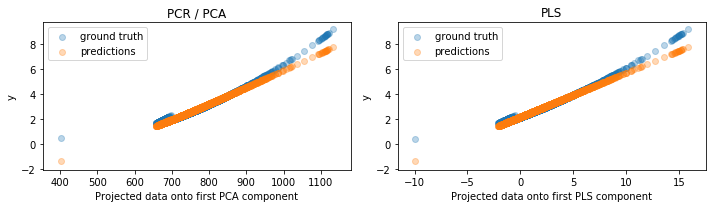

In [29]:
# https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html#sphx-glr-auto-examples-cross-decomposition-plot-pcr-vs-pls-py
# 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
 # Validate you are getting good data for a single asset by plotting data
import matplotlib.pyplot as plt

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps['pca']  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=.3, label='ground truth')
axes[0].scatter(pca.transform(X_test), pcr.predict(X_test), alpha=.3,
                label='predictions')
axes[0].set(xlabel='Projected data onto first PCA component',
            ylabel='y', title='PCR / PCA')
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=.3, label='ground truth')
axes[1].scatter(pls.transform(X_test), pls.predict(X_test), alpha=.3,
                label='predictions')
axes[1].set(xlabel='Projected data onto first PLS component',
            ylabel='y', title='PLS')
axes[1].legend()
plt.tight_layout()
plt.show()

In [32]:
# Assess a prediction 
# extra trees for making predictions for regression
# From Tutorial https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

from sklearn.datasets import make_regression

# Define the model
#model = ExtraTreesRegressor(n_estimators =1000, min_samples_split =0.5)
random_forest_model = RandomForestRegressor()

print ("y_train")
print (y_train)

# fit the model on the whole dataset
#random_forest_model.fit(X_train, y_train.values.ravel() )
random_forest_model.fit(X_train, y_train)

# Predict a single row prediction
#--- x data ---
#       SPEED    FLOW  VOLTAGE  CURRENT  POWER
#0    1053.0  16.294  251.0    7.15     1.556
#131  1071.0  61.006  257.0    7.70     1.950
#132  1077.0  69.099  259.0    7.85     2.024
#133  1082.0  78.005  261.0    7.95     2.148
#134  1085.0  80.894  262.0    8.03     2.154

#--- y data ---
# Power should be 2.154

row = [[ 1085.0,  80.894,  262.0,  8.03]]

yhat = random_forest_model.predict(row)
print("Power should be 2.154")
print(yhat)

# Predict entire training set
x_pos_predictions = random_forest_model.predict(X_test)

print("Predictions")
print ( x_pos_predictions )
print( x_pos_predictions.shape)

# Add the prediction to the dataframe
#s_df['predict_x1_position'] = x_pos_predictions 

y_train
[2.299 1.885 1.74  ... 2.576 2.661 1.777]
Power should be 2.154
[2.16758]
Predictions
[2.46126    2.54168    1.83291    ... 1.72873741 1.72024281 1.72704362]
(13171,)


In [34]:
X_test

array([[1106.   ,  103.034,  269.   ,    8.38 ],
       [1112.   ,  108.441,  271.   ,    8.52 ],
       [1064.   ,   49.124,  254.   ,    7.55 ],
       ...,
       [1059.   ,   37.17 ,  253.   ,    7.38 ],
       [1058.   ,   36.687,  252.   ,    7.38 ],
       [1059.   ,   36.977,  253.   ,    7.35 ]])

Score: 0.9999556156980278


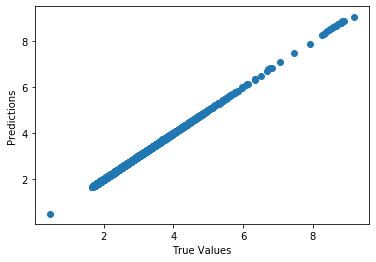

In [35]:
## Plot the prediction The line / model
plt.scatter(y_test, x_pos_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
print('Score:', random_forest_model.score(X_test, y_test) )


In [37]:
# save the model to disk
import pickle
model_file_path = './amstrong_power_random_forest.mod'
pickle.dump(random_forest_model, open(model_file_path, 'wb'))

In [38]:
# Load the model from disk
model = pickle.load(open(model_file_path, 'rb'))

In [39]:
# Test that it is still able to score
# Predict a single row prediction
# Power should be 2.154
row = [[1085.0, 80.894, 262.0, 8.03]]

yhat = model.predict(row)
print(yhat)

[2.16758]


In [112]:
# Get Connection to DB to save and retreive models
from iotfunctions.db import Database
import json
credentials = {}
credential_file = '/Users/carlos.ferreira1ibm.com/ws/predict_delphi/beta-3_credentials.json'

with open(credential_file, encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_ctp = Database(credentials=credentials, entity_type_id=673  )
model_name = 'amstrong_power_random_forest.mod'
print (db_ctp.tenant_id)

beta-3


In [113]:
# Store the model with Datetimestamp and vector to DB db_ctp
from datetime import datetime
model_name = 'amstrong_power_random_forest.mod'
try:
    feature_vector = ['Speed', 'Flow', 'Voltage', 'Current' ]
    model_dict  = {
    'model': model,
    'feature_vector': feature_vector,
    'timesstamp' : datetime.now().strftime("%Y%m%d%H%M%S")
    }
    db_ctp.model_store.store_model(model_name, model_dict)    
except Exception as e:
    print('Model store failed with ' + str(e))
    pass

In [114]:
# Retrieve the model from db
try:
    model_dict = db_ctp.model_store.retrieve_model(model_name)
    print('load model')
    monitor_model = model_dict['model']
    print(monitor_model)
    feature_vector = model_dict['feature_vector']
    print(feature_vector)
    feature_vector = model_dict['timesstamp']
    print(feature_vector)
except Exception as e:
    print('Model retrieval failed with ' + str(e))
    pass

load model
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
['Speed', 'Flow', 'Voltage', 'Current']
20210308090642


In [115]:
# Test that it is still able to score
# Predict a single row prediction
# Power should be 2.154

row = [[ 1085.0,  80.894,  262.0,  8.03]]

mhat = monitor_model.predict(row)
print(mhat)

[2.1574]


In [116]:
print("model_name %s" %model_name)

model_name amstrong_power_random_forest.mod


In [117]:
r_df = pd.read_csv('/Users/carlos.ferreira1ibm.com/ws/predict_delphi/notebooks/Armstrong/iot_pump_de_gen5_NoDup.csv')

/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,22,24,26,27,28,29,41,51,54) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [118]:
entity_type = 'iot_pump_de_gen5'
entity_name = '04714B601096'
print ('r_df.shape 1')
print (r_df.shape)
a_df = r_df.loc[r_df['deviceid'] == entity_name, :]
print ('a_df.shape 1')
print (a_df.shape)
print (a_df)
ac_df = a_df
print ('ac_df.shape 1')
print (ac_df.shape)
print (ac_df)

for col in r_df.columns:
    print(col)

r_df.shape 1
(988367, 55)
a_df.shape 1
(189462, 55)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [40]:
# Make sure you have good data
print ("ac_df.shape")
print (ac_df.shape)

# Convert evt_timestamp so that you can use it to plot x axix by time.
ac_df['updated_utc'] = pd.to_datetime(ac_df['updated_utc'])
print ("plot original time series data")

# Create figure and plot raw data 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis use ax.plot(data time for x axis, pressure for y axis) 
# For line use ax.plot and for bar chart use: ax.bar
ax.plot(ac_df[(ac_df.deviceid == entity_name) 
              & (ac_df['updated_utc'] < pd.Timestamp('2020-12-16 13:41:14.687196'))
              & (ac_df['updated_utc'] > pd.Timestamp('2020-12-16 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        ac_df[(ac_df.deviceid == entity_name) 
              & (ac_df['updated_utc'] < pd.Timestamp('2020-12-16 13:41:14.687196'))
              & (ac_df['updated_utc'] > pd.Timestamp('2020-12-16 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['POWER'],
        color='purple')

# Works Bar chart. Add x-axis and y-axis use ax.plot for line and ax.bar for bar chart
# ax.plot(df.loc[df['deviceid'] == '73001'].sort_values(by='evt_timestamp',ascending=True)['evt_timestamp'],
#        df.loc[df['deviceid'] == '73001'].sort_values(by='evt_timestamp',ascending=True)['drvn_p1'],
#        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Amps",
       title="POWER \n Current")

plt.show()

ac_df.shape
(130971, 55)


KeyError: 'updated_utc'

In [120]:
# Get Connection to DB to retreive models
from iotfunctions.db import Database
credentials = {}
credential_file = '/Users/carlos.ferreira1ibm.com/ws/predict_delphi/beta-3_credentials.json'

with open(credential_file, encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_ctp = Database(credentials=credentials, entity_type_id=673 )
print (db_ctp.tenant_id)
model_name = 'amstrong_power_random_forest.mod'
print("model_name %s" %model_name)

beta-3
model_name amstrong_power_random_forest.mod


In [121]:
# Score the model locally for an individual asset
# Retrieve the model from db
print("model_name %s" %model_name)
try:
    model = db_ctp.model_store.retrieve_model(model_name)
    print('load model')
    monitor_model = model_dict['model']
    print(monitor_model)
    feature_vector = model_dict['feature_vector']
    print(feature_vector)
    feature_vector = model_dict['timesstamp']
    print(feature_vector)
except Exception as e:
    print('Model retrieval failed with ' + str(e))
    pass

model_name amstrong_power_random_forest.mod
load model
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
['Speed', 'Flow', 'Voltage', 'Current']
20210308090642


In [122]:
print ("ac_df columns ")
for col in ac_df.columns:
    print (col)

ac_df columns 
Unnamed: 0
id
devicetype
deviceid
logicalinterface_id
eventtype
format
rcv_timestamp_utc
updated_utc
speed
temperature
head
device_id
pump_mode
flow
warn
kw_hour
voltage
alarm
POWER
CURRENT
TIMESTAMP
vibrations_xaxis
accel_speed
vibrations_yaxis
accel_power
rms_x
rms_z
vibrations_zaxis
rms_y
VERSION
run_qty
tag_number
design_head
perf_option
design_flow
pts
rated_current
rated_speed
hardware_ver
pts_count
serial_number
firmware_ver
reated_power
rmsn_x
vibration_n_yaxis
vibration_n_xaxis
rmsn_y
vibration_n_zaxis
rmsn_z
rms_x_avg
pwr
hw_ver
dq
fw_ver


In [123]:
# Check df for NaN
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
columns = [ 'speed','flow','voltage','CURRENT','POWER', 'deviceid','updated_utc']
s_df = ac_df.loc[ac_df['deviceid'] == entity_name, :][columns]

print ("s_df.shape")
print (s_df.shape)
print (s_df.head() )

s_df.shape
(189462, 7)
    speed     flow  voltage  CURRENT  POWER      deviceid         updated_utc
1 NaN     NaN      NaN      NaN      NaN     04714B601096 2019-12-17 12:01:53
3  1179.0  154.091  296.0    9.71     3.446  04714B601096 2019-12-17 12:03:44
5 NaN     NaN      NaN      NaN      NaN     04714B601096 2019-12-17 12:06:53
7  1194.0  162.155  301.0    10.03    3.651  04714B601096 2019-12-17 12:08:44
9 NaN     NaN      NaN      NaN      NaN     04714B601096 2019-12-17 12:11:54


In [124]:
# Check df for NaN
print(s_df.isnull().values.any())

# Check each column for NaN
print(s_df['speed'].isnull().sum())
print(s_df['flow'].isnull().sum())
print(s_df['voltage'].isnull().sum())
print(s_df['CURRENT'].isnull().sum())
print(s_df['POWER'].isnull().sum())
sc_df = s_df.dropna()
print(sc_df.isnull().values.any())
print ("sc_df.shape")
print (sc_df.shape)
print (sc_df.head() )

True
123597
123597
123597
123597
123597
False
sc_df.shape
(65865, 7)
     speed     flow  voltage  CURRENT  POWER      deviceid         updated_utc
3   1179.0  154.091  296.0    9.71     3.446  04714B601096 2019-12-17 12:03:44
7   1194.0  162.155  301.0    10.03    3.651  04714B601096 2019-12-17 12:08:44
11  1172.0  150.468  293.0    9.68     3.375  04714B601096 2019-12-17 12:13:45
15  1180.0  155.093  296.0    9.74     3.467  04714B601096 2019-12-17 12:18:45
19  1171.0  149.480  293.0    9.57     3.342  04714B601096 2019-12-17 12:23:45


In [125]:
# Select only input colums to predict power using   'flow', 'speed', 'head'
p_df = sc_df.drop(['POWER','deviceid', 'updated_utc'], axis = 1)
print(p_df.shape)
for col in p_df.columns:
    print(col)

power_prediction = monitor_model.predict(p_df)
print(power_prediction)

(65865, 4)
speed
flow
voltage
CURRENT
[2.1918 2.1918 2.1918 ... 2.13   2.1918 2.0376]


In [126]:
print(power_prediction.shape)
sc_df["power_prediction"] = power_prediction
print (sc_df.head() )

(65865,)
     speed     flow  voltage  CURRENT  POWER      deviceid  \
3   1179.0  154.091  296.0    9.71     3.446  04714B601096   
7   1194.0  162.155  301.0    10.03    3.651  04714B601096   
11  1172.0  150.468  293.0    9.68     3.375  04714B601096   
15  1180.0  155.093  296.0    9.74     3.467  04714B601096   
19  1171.0  149.480  293.0    9.57     3.342  04714B601096   

           updated_utc  power_prediction  
3  2019-12-17 12:03:44  2.1918            
7  2019-12-17 12:08:44  2.1918            
11 2019-12-17 12:13:45  2.1918            
15 2019-12-17 12:18:45  2.1918            
19 2019-12-17 12:23:45  2.1918            


/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


sc_df.shape
(65865, 8)
plot original time series data
sc_df.shape
(65865, 8)
     speed     flow  voltage  CURRENT  POWER      deviceid  \
3   1179.0  154.091  296.0    9.71     3.446  04714B601096   
7   1194.0  162.155  301.0    10.03    3.651  04714B601096   
11  1172.0  150.468  293.0    9.68     3.375  04714B601096   
15  1180.0  155.093  296.0    9.74     3.467  04714B601096   
19  1171.0  149.480  293.0    9.57     3.342  04714B601096   

           updated_utc  power_prediction  
3  2019-12-17 12:03:44  2.1918            
7  2019-12-17 12:08:44  2.1918            
11 2019-12-17 12:13:45  2.1918            
15 2019-12-17 12:18:45  2.1918            
19 2019-12-17 12:23:45  2.1918            


/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


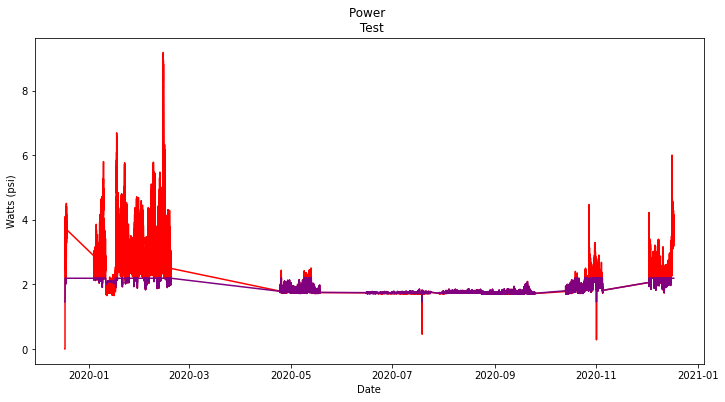

/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


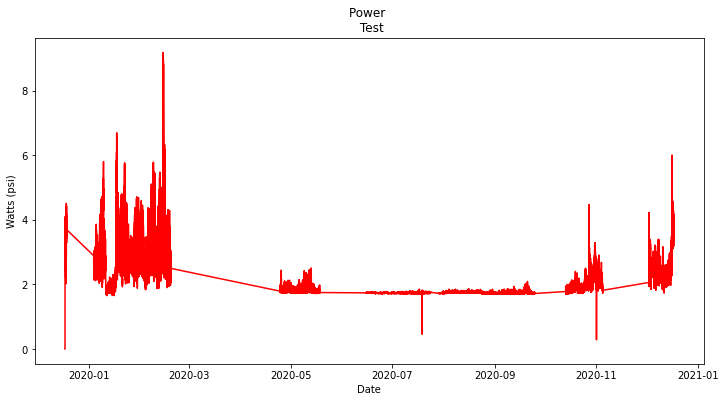

In [127]:
# Plot actual versus prediction power to make sure you have good model
print ("sc_df.shape")
print (sc_df.shape)

# Convert evt_timestamp so that you can use it to plot x axix by time.
sc_df['updated_utc'] = pd.to_datetime(ac_df['updated_utc'])
print ("plot original time series data")

print ("sc_df.shape")
print (sc_df.shape)
print (sc_df.head() )


# Create figure and plot raw data 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))

# Add x-axis and y-axis use ax.plot(data time for x axis, pressure for y axis) 
# For line use ax.plot and for bar chart use: ax.bar
ax.plot(sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-12-17 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2019-12-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        sc_df[(ac_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-12-17 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2019-12-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['POWER'],
        color='red')

ax.plot(sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-12-17 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2019-12-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-12-17 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2019-12-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['power_prediction'],
        color='purple')



# Works Bar chart. Add x-axis and y-axis use ax.plot for line and ax.bar for bar chart
# ax.plot(df.loc[df['deviceid'] == '73001'].sort_values(by='evt_timestamp',ascending=True)['evt_timestamp'],
#        df.loc[df['deviceid'] == '73001'].sort_values(by='evt_timestamp',ascending=True)['drvn_p1'],
#        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Watts (psi)",
       title="Power \n Test")

plt.show()

# Create figure and plot raw data 
import matplotlib.pyplot as plt
fig2, ay = plt.subplots(figsize=(12, 6))
ay.plot(sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-12-17 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2019-12-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        sc_df[(ac_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-12-17 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2019-12-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['POWER'],
        color='red')
# Set title and labels for axes
ay.set(xlabel="Date",
       ylabel="Watts (psi)",
       title="Power \n Test")

plt.show()


In [128]:
# Calulate PPrediction versus actual power deviation over time.
sc_df['power_deviation'] = sc_df['POWER']- sc_df['power_prediction']

/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


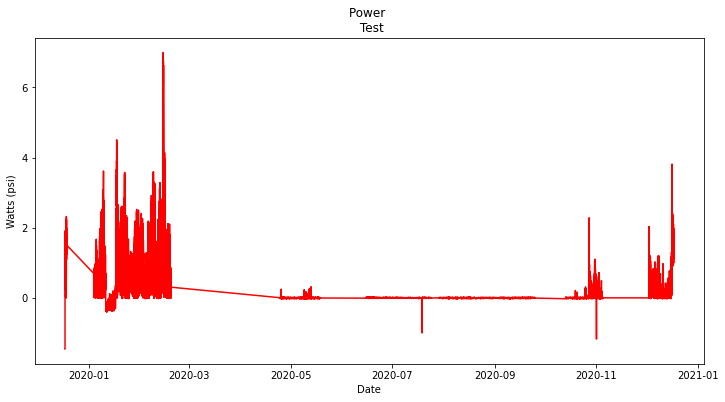

In [129]:
# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Watts (psi)",
       title="Power \n Test")

plt.show()

# Create figure and plot raw data 
import matplotlib.pyplot as plt
fig2, ay = plt.subplots(figsize=(12, 6))
ay.plot(sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-12-17 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2019-12-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        sc_df[(ac_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-12-17 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2019-12-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['power_deviation'],
        color='red')
# Set title and labels for axes
ay.set(xlabel="Date",
       ylabel="Watts (psi)",
       title="Power \n Test")

plt.show()


In [130]:
#Select rows greater than power deviation >6 which is lickly failure date.
print(sc_df.loc[sc_df.power_deviation > 7])

Empty DataFrame
Columns: [speed, flow, voltage, CURRENT, POWER, deviceid, updated_utc, power_prediction, power_deviation]
Index: []


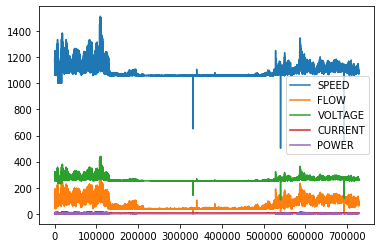

In [44]:
sc_df.plot()

In [45]:
# Sort the dataframe by updated_utc
#sc_df['datetime'] = pd.to_datetime(sc_df['updated_utc'])
#sc_df = sc_df.set_index('datetime')
#sc_df.drop(['updated_utc'], axis=1, inplace=True)
sc_df.head()

,SPEED,FLOW,VOLTAGE,CURRENT,POWER
22,1160.0,141.852,288.0,9.35,3.180
26,1180.0,153.554,296.0,9.74,3.440
30,1164.0,145.109,290.0,9.44,3.230
34,1176.0,152.987,294.0,9.73,3.418
38,1175.0,151.237,294.0,9.64,3.372


In [48]:
from sklearn import preprocessing
import statsmodels.api as sm
import seaborn as sns



In [61]:
### Test for stationarity (part of Data Quality) - p-Value is 2nd value
nd = sc_df['POWER'].values
sm.tsa.stattools.adfuller(nd) 

# Stationary according to ADF

(-5.462783689483561,
 2.496993883892272e-06,
 61,
 65792,
 {'1%': -3.4304493974215062,
  '5%': -2.8615839318513436,
  '10%': -2.5667933834310426},
 -13549.497941729103)

In [76]:
# same again - 2nd value counts
sm.tsa.stattools.kpss(nd, nlags="auto")

# !NON! stationary according to KPSS

/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(8.254766806168677,
 0.01,
 143,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [64]:
# since Power is difference non-stationary we difference and then run ARIMA
ndif = np.diff(nd)

In [65]:


ptfd = preprocessing.PowerTransformer()
kw_boxed = ptfd.fit_transform(ndif.reshape(-1, 1))
kw_log = np.lib.scimath.log(np.abs(ndif) + 10e-4)

Text(0.5, 1.0, 'original data')

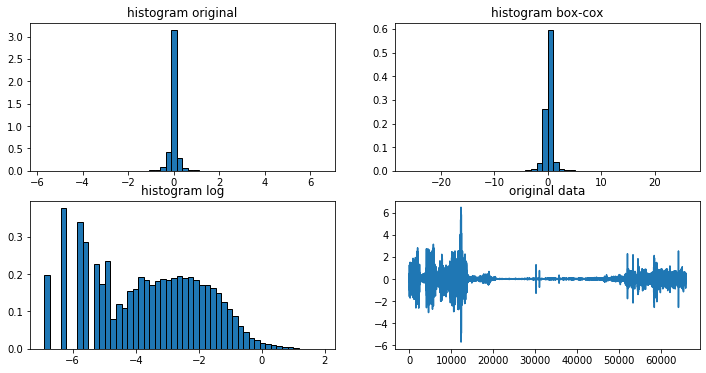

In [66]:
fig, ax = plt.subplots(2, 2,figsize=(12,6), squeeze=False)

ax[0,0].hist(ndif, bins=50, density = True, histtype='bar', ec='black')
ax[0,0].set_title('histogram original')
ax[0,1].hist(kw_boxed, bins=50, density = True, histtype='bar', ec='black')
ax[0,1].set_title('histogram box-cox')
ax[1,0].hist(kw_log, bins=50, density = True, histtype='bar', ec='black')
ax[1,0].set_title('histogram log')
ax[1,1].plot(ndif)
ax[1,1].set_title('original data')

# No need for box-cox

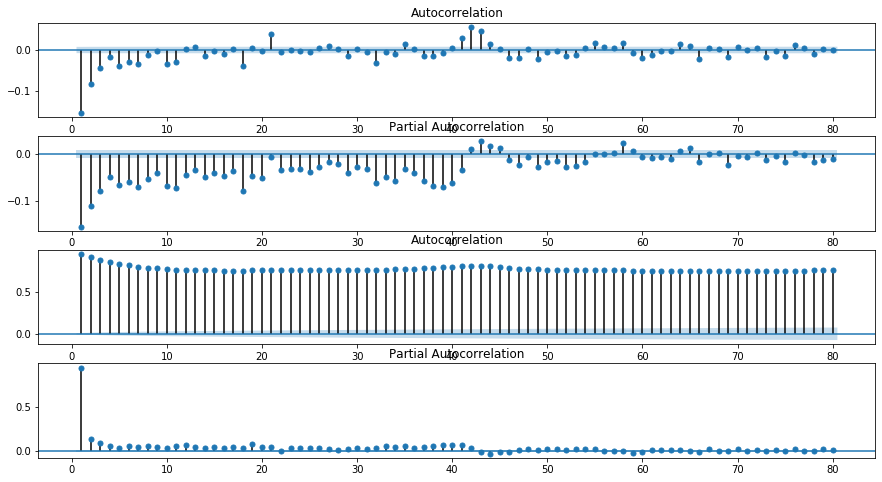

In [71]:
# see old friend https://people.duke.edu/~rnau/411arim3.htm
#
# PACF indicates very very high AR order, significant to order 42 !!
# ACF indicates 
# p = 1, q = 1 + seasonal effects
#
#
fig, ax = plt.subplots(4, 1, figsize=(15, 8), squeeze=False)
x = sm.graphics.tsa.plot_acf(ndif, lags=80, ax=ax[0,0], zero=False)
x = sm.graphics.tsa.plot_pacf(ndif, lags=80, ax=ax[1,0], zero=False)
x = sm.graphics.tsa.plot_acf(nd, lags=80, ax=ax[2,0], zero=False)
x = sm.graphics.tsa.plot_pacf(nd, lags=80, ax=ax[3,0], zero=False)

In [147]:
idx = pd.date_range(start='2020-01-01', periods=sc_df['POWER'].values.shape[0], freq='T', name='timestamp')
#idx.set_name('timestamp')
sc_df.index = idx

In [148]:
sc_df

,SPEED,FLOW,VOLTAGE,CURRENT,POWER
timestamp,,,,,
2020-01-01 00:00:00,1160.0,141.852,288.0,9.35,3.180
2020-01-01 00:01:00,1180.0,153.554,296.0,9.74,3.440
2020-01-01 00:02:00,1164.0,145.109,290.0,9.44,3.230
2020-01-01 00:03:00,1176.0,152.987,294.0,9.73,3.418
2020-01-01 00:04:00,1175.0,151.237,294.0,9.64,3.372
...,...,...,...,...,...
2020-02-15 17:29:00,1084.0,79.537,261.0,7.97,2.148
2020-02-15 17:30:00,1090.0,86.502,263.0,8.10,2.236
2020-02-15 17:31:00,1083.0,79.132,261.0,7.92,2.139


In [235]:
result = sc_df.groupby(pd.Grouper(level='timestamp', freq='H')).agg({'POWER':['mean','std'], 'FLOW':['mean']})

In [237]:
result.columns = [' '.join(col).strip() for col in result.columns.values]

result.columns

Index(['POWER mean', 'POWER std', 'FLOW mean'], dtype='object')

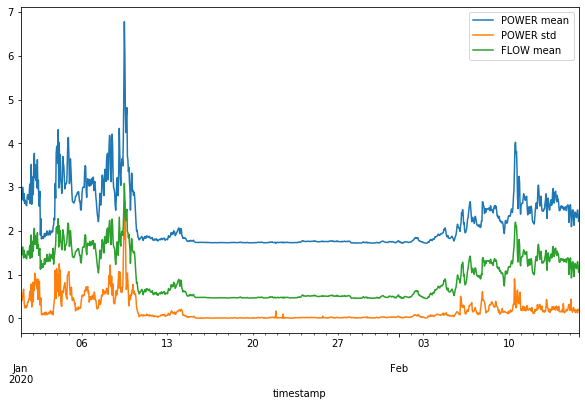

In [238]:
result['FLOW mean'] /= 80
result.plot(figsize=(10,6))

In [162]:
sm.tsa.stattools.adfuller(result['POWER mean'])

(-2.9107758620015263,
 0.04410918463211616,
 21,
 1076,
 {'1%': -3.436441978605957,
  '5%': -2.864229841568573,
  '10%': -2.5682021659802934},
 -917.178361512875)

In [163]:
sm.tsa.stattools.kpss(nd, nlags="auto")

/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(8.254766806168677,
 0.01,
 143,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### Stationarity
barely stationary according to ADF, non-stationary according to KPSS -> differencing

In [164]:
ndif2 = np.diff(result['POWER mean'].values)

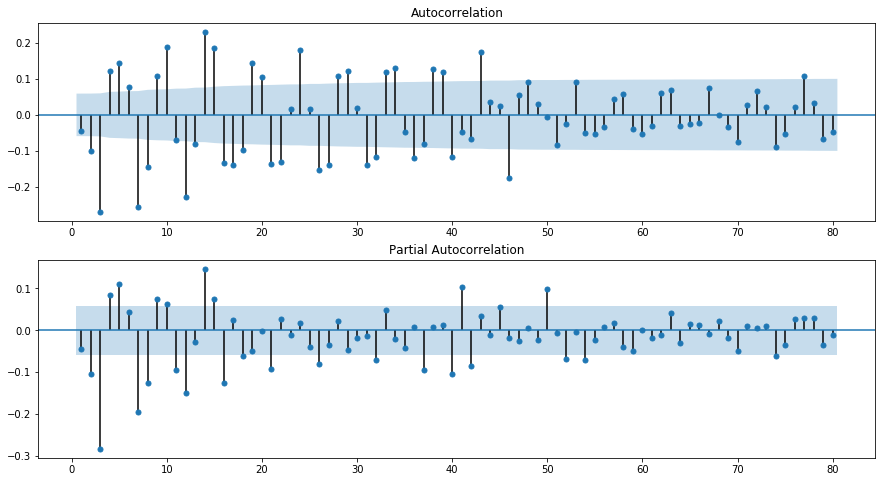

In [167]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), squeeze=False)
x = sm.graphics.tsa.plot_acf(ndif2, lags=80, ax=ax[0,0], zero=False)
x = sm.graphics.tsa.plot_pacf(ndif2, lags=80, ax=ax[1,0], zero=False)

In [172]:
from iotfunctions.dbtables import FileModelStore
from mmfunctions.anomaly import GBMForecaster
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore()
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

###_IBM_###


In [178]:
from iotfunctions.enginelog import EngineLogging
result['entity'] = 'mypump'
result = result.reset_index().set_index(['entity','timestamp'])

ValueError: cannot insert entity, already exists

In [192]:
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = GBMForecaster(['POWER mean'], ['POWER mean'], ['power_mean_pred'], [24,25,26,27,28,29,30])

et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
result = spsi.execute(df=result)

EngineLogging.configure_console_logging(logging.INFO)
result.describe()

2021-03-12T15:24:17.671 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
lags [24, 25, 26, 27, 28, 29, 30]  lagged_features ['POWER mean'] Train mode: True
2021-03-12T15:24:17.673 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 0.0.2
2021-03-12T15:24:17.674 DEBUG iotfunctions.util.__init__ Starting trace
2021-03-12T15:24:17.674 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GBMForecaster_20210312142417
2021-03-12T15:24:17.675 DEBUG iotfunctions.util.__init__ auto_save None
2021-03-12T15:24:17.676 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-03-12T15:24:17.677 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-03-12T15:24:17.678 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GBMFORECASTER
F

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and max_depth = 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and max_depth = 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and 

[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and 

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000008 seconds, init for row-wise cost 0.000886 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 849, number of used features: 7
[LightGBM] [Info] Start training from score 2.156926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and max_depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 25
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 21
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 25
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 27
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 24
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 22
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 25
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 19
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 23
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 28
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 23
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 24
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 22
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 25
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 24
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 24
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 25
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 22
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 27
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 21
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 25
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 25
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 22
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 19
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 21
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 23
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 22
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 24
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 25
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 19
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 23
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 21
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 23
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 23
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and 

,POWER mean,POWER std,power_mean_pred
count,1086.000000,1086.000000,1086.000000
mean,2.178620,0.181208,2.169293
std,0.619233,0.266674,0.582961
min,1.711600,0.002343,1.360378
25%,1.737667,0.014103,1.738776
50%,1.835792,0.070687,1.857511
75%,2.513121,0.235520,2.505832
max,6.780850,2.668319,6.553146


In [212]:
lgbm = spsi.active_models['model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.POWER mean.mypump'][0].estimator['gbm']

valid_x = spsi.active_models['model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.POWER mean.mypump'][1]

In [225]:
features = list(valid_x.columns)
features.pop(0)
features.pop(0)
features.pop(0)
features

['POWER mean_24',
 'POWER mean_25',
 'POWER mean_26',
 'POWER mean_27',
 'POWER mean_28',
 'POWER mean_29',
 'POWER mean_30']

In [226]:
import shap
shap_values = shap.TreeExplainer(lgbm).shap_values(valid_x[features])

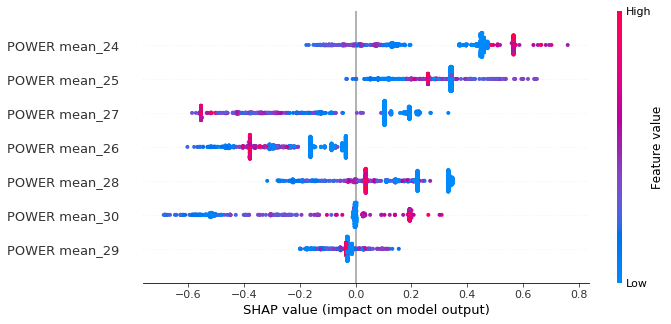

In [227]:
shap.summary_plot(shap_values, valid_x[features], plot_size=(10,5))

In [194]:
result['power_mean_pred'] += 2

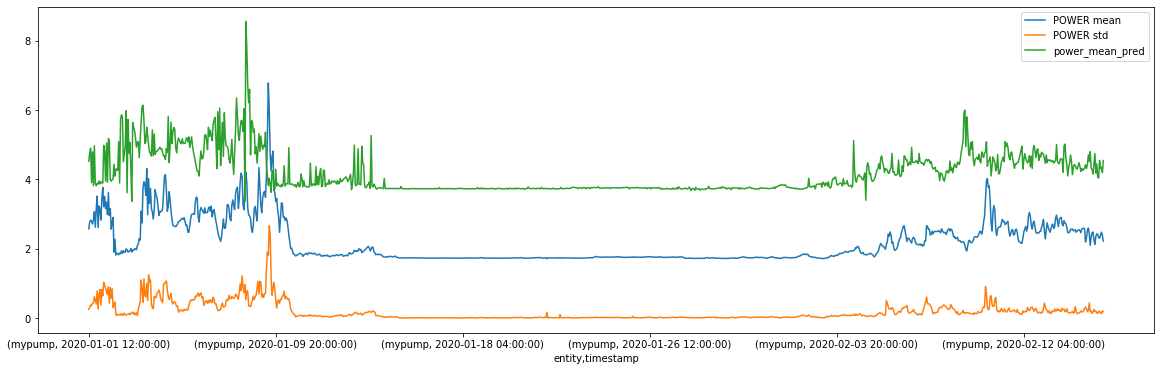

In [195]:

result.plot(figsize=(20,6))

In [132]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

#sc_df.index = sc_df['updated_utc']
#print("after sc_df.index")
#print(sc_df.index)

# Training size to use for forecasting
t_size = 1600

# Load your data into x and y 
print ("--- x data ---")
x = sc_df.filter(['updated_utc'], axis=1)   # Input variables / features P
print (x.head())
print(x.shape)
print( x.info() )

#y = pm.datasets.load_wineind()
#y  = data.to_numpy() 
#print ( y )
# Use y from earlier which is actual power usage sc_df['updated_utc'] and sc_df['POWER']
y = sc_df.filter(['POWER'], axis=1)
print ("--- y data ---")
print (y.head())
print(y.shape)
print( y.info() )

# Split your data into train and test
train, test = train_test_split(y, train_size=t_size)
print ("--- train data ---")
print (train.head())
print(train.shape)
print( train.info() )
print ("--- test data ---")
print (test.head())
print(test.shape)
print( test.info() )


# Fit your model
model = pm.auto_arima(train, seasonal=True, m=12)

# Make your forecasts using test data
forecasts = model.predict(test.shape[0])  # predict N steps into the future

--- x data ---
           updated_utc
3  2019-12-17 12:03:44
7  2019-12-17 12:08:44
11 2019-12-17 12:13:45
15 2019-12-17 12:18:45
19 2019-12-17 12:23:45
(65865, 1)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 65865 entries, 3 to 727675
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   updated_utc  65865 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 3.0 MB
None
--- y data ---
    POWER
3   3.446
7   3.651
11  3.375
15  3.467
19  3.342
(65865, 1)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 65865 entries, 3 to 727675
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   POWER   65865 non-null  float64
dtypes: float64(1)
memory usage: 3.0 MB
None
--- train data ---
    POWER
3   3.446
7   3.651
11  3.375
15  3.467
19  3.342
(1600, 1)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 3 to 6229
Data columns (

/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [133]:
# Add forecasts back to the original dataframe as a new column
print ("--- forecasts data ---")
print(forecasts.shape)
print("forecasts.isna().sum()")
#forecasts.isna().sum()
print(np.count_nonzero(~np.isnan(forecasts)))
print(sc_df.shape)

--- forecasts data ---
(64265,)
forecasts.isna().sum()
64265
(65865, 9)


In [134]:
print(sc_df.iloc[500:530,])

       speed     flow  voltage  CURRENT  POWER      deviceid  \
2058  1170.0  148.449  292.0    9.56     3.320  04714B601096   
2062  1177.0  152.683  295.0    9.68     3.415  04714B601096   
2066  1161.0  143.255  289.0    9.41     3.199  04714B601096   
2070  1184.0  156.869  297.0    9.86     3.526  04714B601096   
2074  1183.0  156.278  297.0    9.79     3.500  04714B601096   
2078  1063.0  46.828   254.0    7.49     1.817  04714B601096   
2079  1196.0  163.398  302.0    10.01    3.682  04714B601096   
2083  1189.0  157.884  299.0    9.87     3.550  04714B601096   
2087  1171.0  149.294  293.0    9.62     3.336  04714B601096   
2091  1166.0  146.424  291.0    9.52     3.267  04714B601096   
2095  1153.0  137.527  286.0    9.23     3.084  04714B601096   
2099  1150.0  136.102  285.0    9.20     3.050  04714B601096   
2103  1131.0  122.987  278.0    8.89     2.797  04714B601096   
2107  1115.0  110.360  272.0    8.56     2.581  04714B601096   
2111  1118.0  112.848  273.0    8.59    

/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


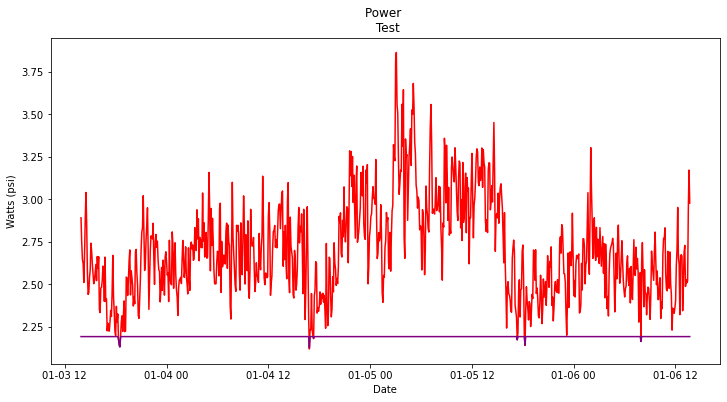

In [135]:
#Plot before forecast available
# Create figure and plot raw data 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))

# Add x-axis and y-axis use ax.plot(data time for x axis, pressure for y axis) 
# For line use ax.plot and for bar chart use: ax.bar
ax.plot(sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        sc_df[(ac_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['POWER'],
        color='red')

ax.plot(sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['power_prediction'],
        color='purple')


# Works Bar chart. Add x-axis and y-axis use ax.plot for line and ax.bar for bar chart
# ax.plot(df.loc[df['deviceid'] == '73001'].sort_values(by='evt_timestamp',ascending=True)['evt_timestamp'],
#        df.loc[df['deviceid'] == '73001'].sort_values(by='evt_timestamp',ascending=True)['drvn_p1'],
#        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Watts (psi)",
       title="Power \n Test")

plt.show()

In [136]:
# Save the forecast as a new metric column in the orginal dataframe.
#print(sc_df.iloc[:100,])

print(forecasts.shape)
sc_df['forecast_power'] = pd.Series(forecasts)
print(sc_df['forecast_power'].isnull().sum())
sc_df.head()

print(sc_df.head())
for col in sc_df.columns:
    print(col)

#print("Before")
#print(sc_df.isnull().values.any())
#print(s_df['POWER'].isnull().sum())
#sc_df = s_df.dropna()
#print("After")
#print(sc_df.isnull().values.any())
#print("sc_df.tail")
#print(sc_df.iloc[:100,])

(64265,)
56593
     speed     flow  voltage  CURRENT  POWER      deviceid  \
3   1179.0  154.091  296.0    9.71     3.446  04714B601096   
7   1194.0  162.155  301.0    10.03    3.651  04714B601096   
11  1172.0  150.468  293.0    9.68     3.375  04714B601096   
15  1180.0  155.093  296.0    9.74     3.467  04714B601096   
19  1171.0  149.480  293.0    9.57     3.342  04714B601096   

           updated_utc  power_prediction  power_deviation  forecast_power  
3  2019-12-17 12:03:44  2.1918            1.2542           2.719521        
7  2019-12-17 12:08:44  2.1918            1.4592           2.755794        
11 2019-12-17 12:13:45  2.1918            1.1832           2.768938        
15 2019-12-17 12:18:45  2.1918            1.2752           2.773300        
19 2019-12-17 12:23:45  2.1918            1.1502           2.776829        
speed
flow
voltage
CURRENT
POWER
deviceid
updated_utc
power_prediction
power_deviation
forecast_power


/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


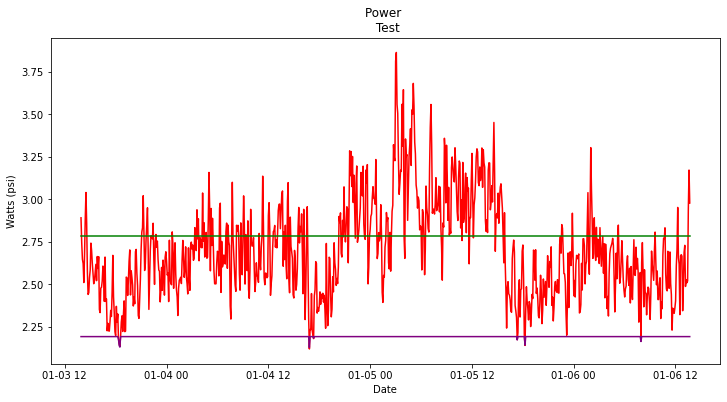

In [137]:
#Plot after adding forecast
# Create figure and plot raw data 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))

# Add x-axis and y-axis use ax.plot(data time for x axis, pressure for y axis) 
# For line use ax.plot and for bar chart use: ax.bar
ax.plot(sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        sc_df[(ac_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['POWER'],
        color='red')

ax.plot(sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['power_prediction'],
        color='purple')

ax.plot(sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['forecast_power'],
        color='green')




# Works Bar chart. Add x-axis and y-axis use ax.plot for line and ax.bar for bar chart
# ax.plot(df.loc[df['deviceid'] == '73001'].sort_values(by='evt_timestamp',ascending=True)['evt_timestamp'],
#        df.loc[df['deviceid'] == '73001'].sort_values(by='evt_timestamp',ascending=True)['drvn_p1'],
#        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Watts (psi)",
       title="Power \n Test")

plt.show()

In [138]:
print(x[:500].sort_values(by='updated_utc',ascending=True))

             updated_utc
60   2019-12-17 07:46:41
56   2019-12-17 07:46:41
52   2019-12-17 07:46:41
48   2019-12-17 07:46:41
40   2019-12-17 07:46:41
44   2019-12-17 07:46:41
50   2019-12-17 07:48:32
58   2019-12-17 07:48:32
42   2019-12-17 07:48:32
46   2019-12-17 07:48:32
54   2019-12-17 07:48:32
62   2019-12-17 08:13:33
66   2019-12-17 08:18:34
70   2019-12-17 08:23:34
74   2019-12-17 08:28:34
78   2019-12-17 08:33:34
82   2019-12-17 08:38:34
86   2019-12-17 08:43:34
90   2019-12-17 08:48:35
92   2019-12-17 10:08:38
96   2019-12-17 10:13:38
304  2019-12-17 10:18:39
308  2019-12-17 10:23:39
312  2019-12-17 10:28:40
316  2019-12-17 10:33:40
320  2019-12-17 10:38:40
324  2019-12-17 10:43:40
328  2019-12-17 10:48:41
334  2019-12-17 10:53:41
338  2019-12-17 10:58:41
342  2019-12-17 11:03:42
636  2019-12-17 11:08:42
640  2019-12-17 11:13:42
644  2019-12-17 11:18:42
648  2019-12-17 11:23:42
652  2019-12-17 11:28:43
656  2019-12-17 11:33:43
660  2019-12-17 11:38:43
664  2019-12-17 11:43:43


/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


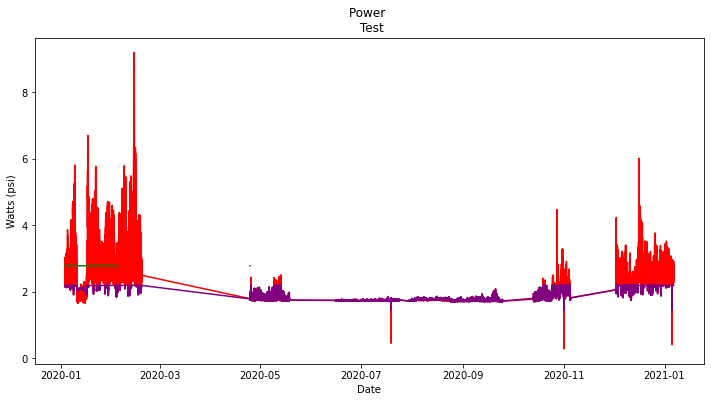

In [139]:
#Plot after adding forecast full year
#Plot after adding forecast
# Create figure and plot raw data 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))

# Add x-axis and y-axis use ax.plot(data time for x axis, pressure for y axis) 
# For line use ax.plot and for bar chart use: ax.bar
ax.plot(sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2021-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        sc_df[(ac_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2021-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['POWER'],
        color='red')

ax.plot(sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2021-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2021-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['power_prediction'],
        color='purple')

ax.plot(sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2021-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2021-01-06 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2020-01-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['forecast_power'],
        color='green')




# Works Bar chart. Add x-axis and y-axis use ax.plot for line and ax.bar for bar chart
# ax.plot(df.loc[df['deviceid'] == '73001'].sort_values(by='evt_timestamp',ascending=True)['evt_timestamp'],
#        df.loc[df['deviceid'] == '73001'].sort_values(by='evt_timestamp',ascending=True)['drvn_p1'],
#        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Watts (psi)",
       title="Power \n Test")

plt.show()

In [140]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Sort the dataframe by updated_utc
d_df = sc_df
d_df['datetime'] = pd.to_datetime(d_df['updated_utc'])
d_df = d_df.set_index('datetime')
#d_df.drop(['updated_utc'], axis=1, inplace=True)

d_df.head()



/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,speed,flow,voltage,CURRENT,POWER,deviceid,updated_utc,power_prediction,power_deviation,forecast_power
datetime,,,,,,,,,,
2019-12-17 12:03:44,1179.0,154.091,296.0,9.71,3.446,04714B601096,2019-12-17 12:03:44,2.1918,1.2542,2.719521
2019-12-17 12:08:44,1194.0,162.155,301.0,10.03,3.651,04714B601096,2019-12-17 12:08:44,2.1918,1.4592,2.755794
2019-12-17 12:13:45,1172.0,150.468,293.0,9.68,3.375,04714B601096,2019-12-17 12:13:45,2.1918,1.1832,2.768938
2019-12-17 12:18:45,1180.0,155.093,296.0,9.74,3.467,04714B601096,2019-12-17 12:18:45,2.1918,1.2752,2.773300
2019-12-17 12:23:45,1171.0,149.480,293.0,9.57,3.342,04714B601096,2019-12-17 12:23:45,2.1918,1.1502,2.776829


In [141]:
print(d_df.index)
print(d_df.tail(10))

DatetimeIndex(['2019-12-17 12:03:44', '2019-12-17 12:08:44',
               '2019-12-17 12:13:45', '2019-12-17 12:18:45',
               '2019-12-17 12:23:45', '2019-12-17 12:28:45',
               '2019-12-17 12:33:46', '2019-12-17 12:38:45',
               '2019-12-17 12:43:46', '2019-12-17 12:48:46',
               ...
               '2021-01-11 16:13:40', '2021-01-11 16:18:40',
               '2021-01-11 19:03:47', '2021-01-11 19:08:47',
               '2021-01-11 19:13:48', '2021-01-11 18:23:45',
               '2021-01-11 18:28:46', '2021-01-11 18:33:46',
               '2021-01-11 16:23:40', '2021-01-11 19:18:48'],
              dtype='datetime64[ns]', name='datetime', length=65865, freq=None)
                      speed    flow  voltage  CURRENT  POWER      deviceid  \
datetime                                                                     
2021-01-11 16:13:40  1077.0  70.173  259.0    7.86     2.042  04714B601096   
2021-01-11 16:18:40  1084.0  79.537  261.0    7.97     2

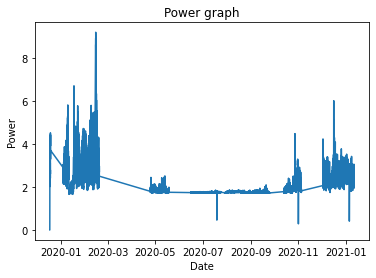

In [142]:
plt.xlabel("Date")
plt.ylabel("Power")
plt.title("Power graph")
plt.plot(d_df.sort_values(by='datetime',ascending=True)['POWER'])

In [144]:
#Select rows = or less than 0 and drop them
print(d_df.loc[d_df.POWER <= 0])


                     speed  flow  voltage  CURRENT  POWER      deviceid  \
datetime                                                                  
2019-12-17 07:46:41  0.0    0.0   0.0      0.0      0.0    04714B601096   
2019-12-17 07:48:32  0.0    0.0   0.0      0.0      0.0    04714B601096   
2019-12-17 07:46:41  0.0    0.0   0.0      0.0      0.0    04714B601096   
2019-12-17 07:48:32  0.0    0.0   0.0      0.0      0.0    04714B601096   
2019-12-17 07:46:41  0.0    0.0   0.0      0.0      0.0    04714B601096   
2019-12-17 07:48:32  0.0    0.0   0.0      0.0      0.0    04714B601096   
2019-12-17 07:46:41  0.0    0.0   0.0      0.0      0.0    04714B601096   
2019-12-17 07:48:32  0.0    0.0   0.0      0.0      0.0    04714B601096   
2019-12-17 07:46:41  0.0    0.0   0.0      0.0      0.0    04714B601096   
2019-12-17 07:48:32  0.0    0.0   0.0      0.0      0.0    04714B601096   
2019-12-17 07:46:41  0.0    0.0   0.0      0.0      0.0    04714B601096   

                        

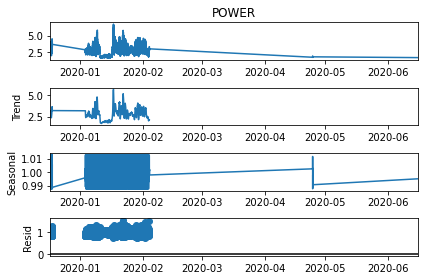

In [145]:
from statsmodels.tsa.seasonal import seasonal_decompose
d_df = d_df.dropna()
result = seasonal_decompose(d_df[d_df.POWER > 0] .sort_values(by='datetime',ascending=True)['POWER'], model='multiplicative', freq=60)
result.plot()
plt.show()

In [146]:
print(d_df.tail(10))

                      speed     flow  voltage  CURRENT  POWER      deviceid  \
datetime                                                                      
2020-02-03 16:20:13  1080.0  74.530   260.0    7.87     2.094  04714B601096   
2020-02-03 16:25:13  1076.0  68.405   259.0    7.79     2.027  04714B601096   
2020-02-03 16:30:13  1082.0  77.810   261.0    7.92     2.128  04714B601096   
2020-02-04 01:30:18  1098.0  95.436   266.0    8.29     2.353  04714B601096   
2020-02-04 01:35:18  1107.0  103.455  269.0    8.44     2.472  04714B601096   
2020-02-04 03:15:19  1155.0  138.642  287.0    9.27     3.109  04714B601096   
2020-02-04 03:20:19  1174.0  149.944  294.0    9.59     3.364  04714B601096   
2020-02-04 03:25:19  1153.0  138.005  286.0    9.22     3.090  04714B601096   
2020-02-04 03:30:19  1139.0  128.772  281.0    9.01     2.912  04714B601096   
2020-02-04 03:35:19  1129.0  120.614  277.0    8.83     2.760  04714B601096   

                            updated_utc  power_pred

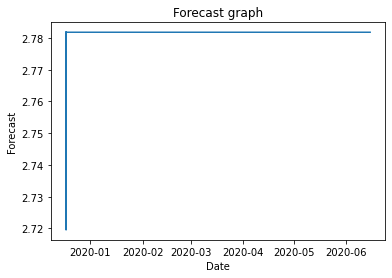

In [148]:
plt.title("Forecast graph")
plt.ylabel("Forecast")
plt.xlabel("Date")
plt.plot(d_df.sort_values(by='datetime',ascending=True)['forecast_power'])
plt.show()

In [149]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(sc_df, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())


ModuleNotFoundError: No module named 'pyramid'

In [47]:
#print(y[:500].sort_values(by='updated_utc',ascending=True))

KeyError: 'updated_utc'

In [ ]:
print(train[:500].sort_values(by='updated_utc',ascending=True))

In [ ]:
print(x[:t_size])

In [ ]:
# Visualize the forecasts (blue=train, green=forecasts)

#x = np.arange(y.shape[0])
plt.figure(figsize=(12, 6))
plt.title('Power \n Forecast',fontsize=24)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Watts',fontsize=14)
plt.tick_params(axis='both',labelsize=14)

plt.plot(x[:t_size].sort_values(by='datetime',ascending=True), train.sort_values(by='datetime',ascending=True), c='blue',linewidth=5)
plt.plot(x[t_size:].sort_values(by='datetime',ascending=True), forecasts, c='green')
plt.plot(x[t_size:].sort_values(by='datetime',ascending=True), y[t_size:].sort_values(by='datetime',ascending=True), c='red')
plt.show()

In [ ]:
# Create figure and plot raw data 
import matplotlib.pyplot as plt
fig2, ay = plt.subplots(figsize=(12, 6))
ay.plot(x[:t_size].sort_index(),
        y[:t_size].sort_index(),
        color='red')
# Set title and labels for axes
ay.set(xlabel="Date",
       ylabel="Watts (psi)",
       title="Power \n Test")

plt.show()

In [ ]:
print(y.shape[0])

# Visualize the forecasts (blue=train, green=forecasts)
#x = sc_df['updated_utc']
x = np.arange(y.shape[0])

plt.title('Power \n Forecast',fontsize=20)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Watts',fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.figsize=(12, 6)
plt.plot(x[:t_size], train, c='blue')
plt.plot(x[t_size:], forecasts, c='green')
plt.plot(x[t_size:], y[t_size:], c='red')
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6
plt.show()

In [ ]:
print(forecasts)
print(forecasts.shape)
print(sc_df.shape)

In [ ]:
# Find the date when the power forecast is greater than  max_power

#df[df['price'].gt(99)].index[0]

#next(x[0] for x in enumerate(forecasts) if x[1] > 1)

#Try this: "> 99"

#df[df['price'].gt(99)].index[0]
#returns "2", the second index row.

#all row indexes greater than 99

#df[df['price'].gt(99)].index
#Int64Index([2, 5, 6], dtype='int64')

In [ ]:
print(sc_df['updated_utc'].tail(1))
print("pd.Timestamp")
print(pd.Timestamp('2020-12-17 13:41:14.687196'))



In [189]:
# START HERE when you already have a csv file
import json
import logging
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import bif
#import sklearn.external.joblib as extjoblib
import joblib


from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.base import BaseTransformer
from iotfunctions.bif import EntityDataGenerator

import datetime as dt
from datetime import datetime

import modin.pandas as pd
import numpy as np

import modin.pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
import sklearn


/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


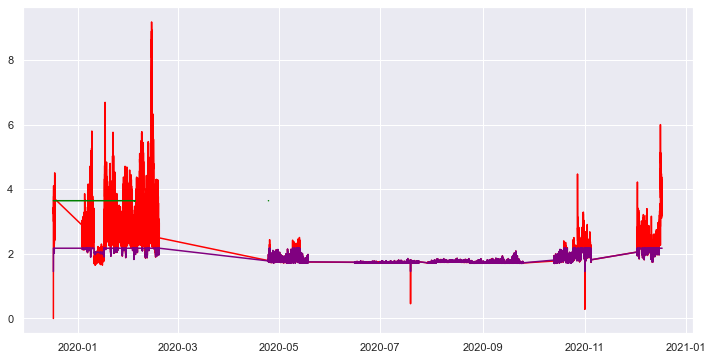

In [190]:
# Create figure and plot raw data and forecast
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))

# Add x-axis and y-axis use ax.plot(data time for x axis, pressure for y axis) 
# For line use ax.plot and for bar chart use: ax.bar
ax.plot(sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-12-17 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2019-12-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        sc_df[(ac_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-12-17 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2019-12-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['POWER'],
        color='red')

ax.plot(sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-12-17 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2019-12-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-12-17 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2019-12-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['power_prediction'],
        color='purple')

ax.plot(sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-12-17 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2019-12-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['updated_utc'],
        sc_df[(sc_df.deviceid == entity_name) 
              & (sc_df['updated_utc'] < pd.Timestamp('2020-12-17 13:41:14.687196'))
              & (sc_df['updated_utc'] > pd.Timestamp('2019-12-01 12:41:14.687196'))
             ].sort_values(by='updated_utc',ascending=True)['forecast_power'],
        color='green')
